In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(".", "transformers")))
from preprocessing_part_2 import * 
from column_selectors import *
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

In [2]:
new_train_df = pd.read_csv('dataframes/train_geo_clustered.csv')
new_val_df = pd.read_csv('dataframes/val_geo_clustered.csv')

*This dataframe is already split into train,val,test in Feature Engineering file and saved to csv*

In [3]:
# we have a train df with a new column from first clusterization
new_train_df.head(2)

,name,latitude,longitude,review_count,rating,Friday,Saturday,Sunday,Monday,Tuesday,...,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,Website_known,Phone_known,main_category,geo_cluster
0,Lead Handyman Services,25.324796,55.417346,-0.135231,1.061147,8-11 AM,8 AM-6 PM,8 AM-6 PM,8 AM-6 AM,8 AM-6 PM,...,0,0,0,0,0,0,1,1,Service,0
1,Sunil Ambalavelil - Lawyer and Legal Consultan...,25.188190,55.271341,-0.136699,1.061147,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,...,0,0,0,0,0,0,1,1,Attorney,0


# Feature engineering part 2

We still have some columns to delete:
* name - is unique for every company
* latitude and longitude - these features were used for first clustering, now we have geo_cluster so we don't need them anymore
* Friday,...Sunday - We already have binary columns like monday_morning/monday_evening etc

Column that we have to encode: main category

In [4]:
pipes1 = Pipeline([('remove_more_cols',MoreColumnsRemover()), # removing irrelevant columns mentioned above
                   ('encoder', CategoryEncoder()),    # one hot encoding 'main'category' column
                   ('bool_encode', BooleanToNumericEncoder())]) 
train_df = pipes1.fit_transform(new_train_df)

<Axes: >

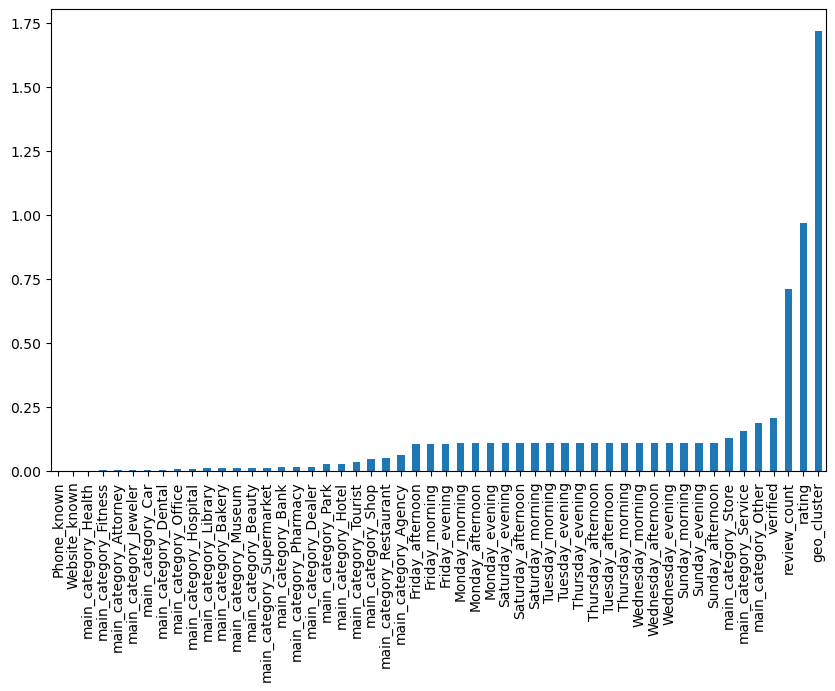

In [5]:
#check column's variances before standarization
variances = train_df.var()
sorted_variances = variances.sort_values()
plt.figure(figsize=(10, 6))
sorted_variances.plot(kind='bar')

In [6]:
print("Wariancje cech:\n", sorted_variances)

Wariancje cech:
 Phone_known                  0.000000
Website_known                0.000000
main_category_Health         0.000665
main_category_Fitness        0.002653
main_category_Attorney       0.003512
main_category_Jeweler        0.003974
main_category_Car            0.004765
main_category_Dental         0.005686
main_category_Office         0.007720
main_category_Hospital       0.008505
main_category_Library        0.010201
main_category_Bakery         0.011112
main_category_Museum         0.011242
main_category_Beauty         0.013058
main_category_Supermarket    0.013640
main_category_Bank           0.014157
main_category_Pharmacy       0.014932
main_category_Dealer         0.016027
main_category_Park           0.025955
main_category_Hotel          0.029029
main_category_Tourist        0.034249
main_category_Shop           0.046427
main_category_Restaurant     0.049119
main_category_Agency         0.064261
Friday_afternoon             0.106481
Friday_morning               0.10

Variance analysis will help us with selecting the best dataframe to use in clustering.

We will create 3 selectors to select different subsets of columns in column_selector.py file.

## Feature selection

In [6]:
selector1 = Pipeline([('three_biggest_var', FirstColumnSelector())])
selector2 = Pipeline([('Variance_greater_than_015' ,SecondColumnSelector())])
selector3 = Pipeline([('Variance_greater_than_0', ThirdColumnSelector())])

train_df1 = selector1.fit_transform(train_df)
train_df2 = selector2.fit_transform(train_df)
train_df3 = selector3.fit_transform(train_df)

## Feature standardization

In [7]:
standardizer = Pipeline([('standardizer', SecondStandardizer())])

train_df1 = standardizer.fit_transform(train_df1)
train_df2 = standardizer.fit_transform(train_df2)
train_df3 = standardizer.fit_transform(train_df3)

### At this point we have 3 dataframes to use. The most general one is train_df3 (we only removed columns with variance 0)

# PCA

In [8]:
#let's see if we can achieve little information loss with only 2 components
def print_explained_variance(df):
    pca = PCA(n_components=2)
    pca.fit(df)
    print(pca.explained_variance_)

In [9]:
print_explained_variance(train_df1)
print_explained_variance(train_df2)
print_explained_variance(train_df3)

[1.14080841 0.98741062]
[1.52048639 1.13831559]
[20.59779486  1.57086727]


Explained variance measures the proportion of variance in the data that is explained by each principal component. 

We can see very low percentages for 1 and 2 dataframe and only 20 % for the third one.

In [10]:
def print_optimal_components(df, trehslod):
    pca = PCA(trehslod)
    pca.fit(df)
    print(pca.n_components_)

In [11]:
print_optimal_components(train_df3, 0.85) # no point in checking for df1 and df2 as they have just a few columns

21


In order to have 85% of the variance explained we need 21 components. Our dataframe has 50 so that is less than half of the features that we would need withou pca

# Model building and evaluation

First let's look at some evaluation metrics that we will use for chooseing the best model.
1. **Silhouuette Score** - how each point is similar to other points in it's cluster (form -1 to 1)
2. **Davies-Bouldin Index** - how a given cluster is similar to the next one (the higher the score the worse)
3. **Calinski-Harabasz Index** - ratio of the between-cluster separation to the within-cluster dispersion (the higher the better)

In [12]:
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
def create_report(model, data):
    model.fit(data)
    labels = model.predict(data)

    silhouette = silhouette_score(data,labels)
    davies = davies_bouldin_score(data,labels)
    calinski = calinski_harabasz_score(data,labels)

    result = pd.DataFrame({
        'Metric': ['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score'],
        'Score': [silhouette, davies, calinski]
    })

    print(result)


# Model 1 - KMeans

In [13]:
#how many clusters should we use?
def print_elbows(data):
    inertia=[]
    for k in range (1,11):
        model = KMeans(n_clusters=k)
        model.fit(data) 
        inertia.append(model.inertia_)
    plt.figure(figsize=(8,6))
    plt.plot(range(1,11), inertia, marker='o', linestyle='-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title("Elbow plot")
    plt.xticks(np.arange(1,11,1))
    plt.show()

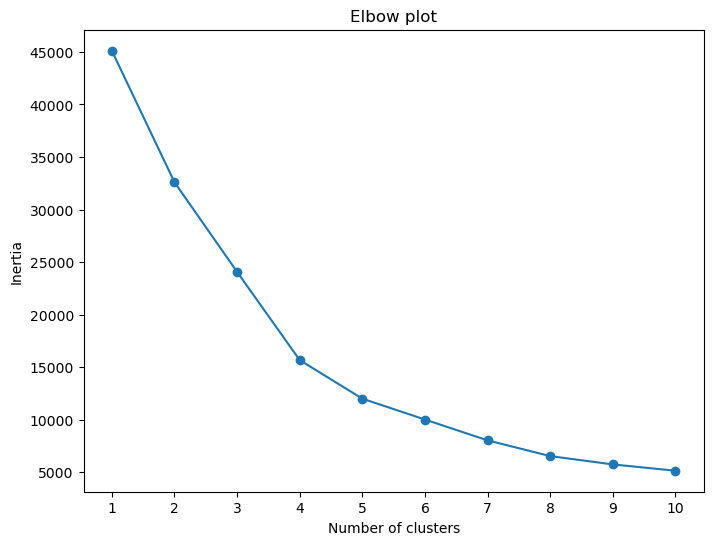

In [14]:
print_elbows(train_df1)

We can see the albow at 4-6 clusters for first df

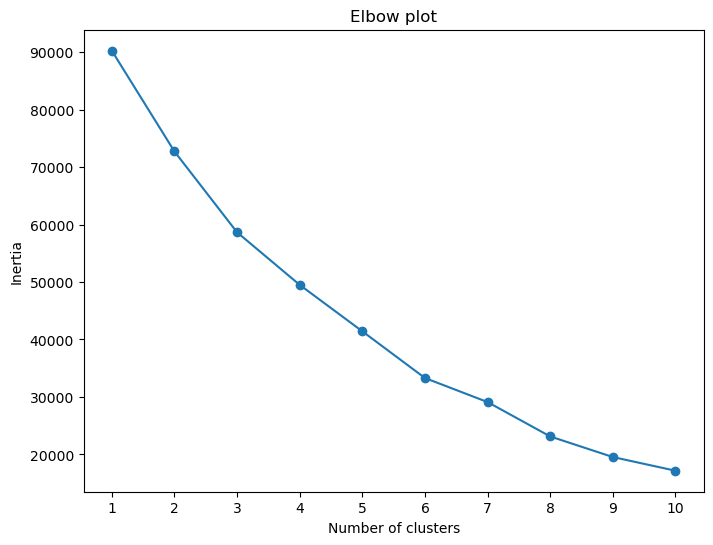

In [25]:
print_elbows(train_df2)

There is no obvious elbow for df2 but maybe around 6 or 9

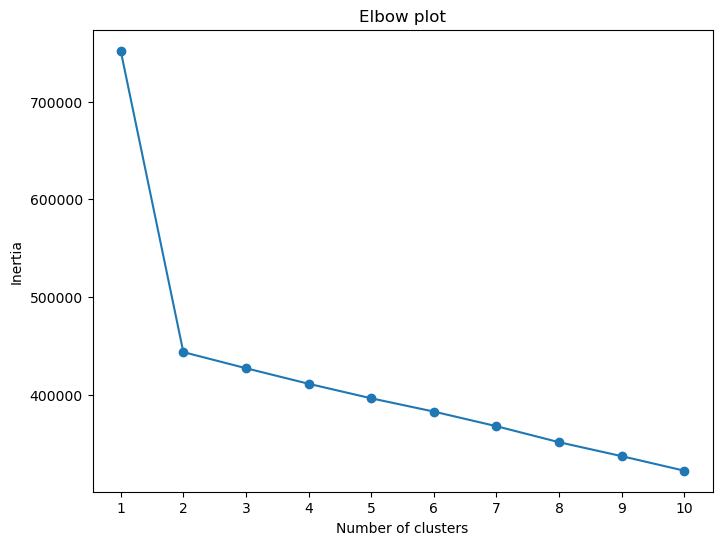

In [26]:
print_elbows(train_df3)

Here optimal number of clusters would be 2

In [15]:
model = KMeans(n_clusters=5)
create_report(model,train_df1)

                    Metric         Score
0         Silhouette Score      0.605611
1     Davies-Bouldin Score      0.579593
2  Calinski-Harabasz Score  10389.215118


In [16]:
model=KMeans(n_clusters=9)
create_report(model, train_df2)

                    Metric        Score
0         Silhouette Score     0.545451
1     Davies-Bouldin Score     0.700602
2  Calinski-Harabasz Score  6795.772017


A little better score for with PCA

In [17]:
model = KMeans(n_clusters=2)
create_report(model,train_df3)

                    Metric         Score
0         Silhouette Score      0.577365
1     Davies-Bouldin Score      0.647624
2  Calinski-Harabasz Score  10436.260614


In [18]:
model = KMeans(n_clusters=2)
pca = PCA(0.85)
create_report(model,pca.fit_transform(train_df3))

                    Metric         Score
0         Silhouette Score      0.616223
1     Davies-Bouldin Score      0.562420
2  Calinski-Harabasz Score  13928.519985


Best results for train_df3 with PCA or train_df1. Let's try to tune parameters

In [53]:
param_grid={
    'n_clusters': range(2, 15),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [300,400, 600]
}

model = KMeans()
reduced_df = pca.fit_transform(train_df3)
scoring = 'silhouette'
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='explained_variance')
grid_search.fit(reduced_df)

best_model = grid_search.best_estimator_

In [20]:
model = KMeans(n_clusters=2,n_init=10, max_iter=600)
pca = PCA(0.85)
create_report(model,pca.fit_transform(train_df3))

                    Metric         Score
0         Silhouette Score      0.616223
1     Davies-Bouldin Score      0.562420
2  Calinski-Harabasz Score  13928.519985


results remain the same after parameter tuning

# DBSCAN